# **WiSAR Vision System: YOLO11m**

1. **Project:** Autonomous UAV Swarm for Wilderness Search and Rescue
2. **Module:** Vision Enriched (performance maximization)
3. **Model:** YOLO11 Medium 

---

### Description
This notebook implements the **High-Performance Strategy**.
By using a larger model architecture (Medium) combined with the variance-rich **SARD dataset**, this experiment aims to find the upper bound of detection capability.
* **Key Result:** Achieved the project's highest **mAP@50 (0.884)**.
* **Purpose:** Validates the effectiveness of data enrichment when hardware constraints are lifted.

In [ ]:
#ERONMENT CLEANUP (to remove buggy OpenCV 4.12.x) AND GENERAL SETUP

#Removing Tensorflow (to save space/conflicts) and any existing OpenCV
get_ipython().system('pip uninstall -y tensorflow opencv-python opencv-python-headless opencv-contrib-python')

#SAFE INSTALLATION
#Installing the specific OpenCV version known to work with YOLO first
get_ipython().system('pip install "opencv-python-headless==4.8.0.74"')

#Installing Ultralytics without automatically installing its dependencies (to avoid overwriting OpenCV)
get_ipython().system('pip install ultralytics gdown tqdm --no-deps')

#Manually installing other necessary dependencies for YOLO (numpy, torch, etc.)
get_ipython().system('pip install matplotlib>=3.3.0 numpy>=1.23.0 pillow>=7.1.2 pyyaml>=5.3.1 requests>=2.23.0 scipy>=1.4.1 torch>=1.8.0 torchvision>=0.9.0 psutil pandas seaborn')

import torch
import ultralytics
import cv2 

print("\n" + "="*40)
print(f"PyTorch: {torch.__version__}")
print(f"YOLO:    {ultralytics.__version__}")
print(f"OpenCV:  {cv2.__version__}  <-- MUST BE 4.8.0.74") 
print("="*40)

if cv2.__version__.startswith("4.12"):
    print("WARNING: OpenCV 4.12 still detected. Perform factory reset and try again.")
else:
    print("Correct OpenCV version.")

if torch.cuda.is_available():
    DEVICE = 0 
    gpu_name = torch.cuda.get_device_name(0)
    vram = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU DETECTED: {gpu_name} ({vram:.2f} GB VRAM)")
else:
    DEVICE = 'cpu'
    print("No GPU detected")
print("="*40 + "\n")

In [ ]:
import os
import cv2
import glob
from tqdm.notebook import tqdm
import random
import shutil

#PATH CONFIGURATION
#Root search with the 3 subfolders (train, test, valid)

INPUT_ROOT_DIR = "/kaggle/input/heridal-clean-dataset"
INPUT_ROOT_DIR = "/kaggle/input/heridal-4k"
OUTPUT_BASE_DIR = "/kaggle/working/dataset_tiled"

TILE_SIZE = 640
OVERLAP = 0.2
EMPTY_RATIO = 0.02

SUBSETS = ['train', 'valid', 'test']

#Cleaning up previous output
if os.path.exists(OUTPUT_BASE_DIR):
    shutil.rmtree(OUTPUT_BASE_DIR)

#Conversion functions
def yolo_to_pixel(yolo_line, img_w, img_h):
    parts = list(map(float, yolo_line.split()))
    c = int(parts[0])
    x, y, w, h = parts[1], parts[2], parts[3], parts[4]
    x1 = (x - w/2) * img_w; y1 = (y - h/2) * img_h
    x2 = (x + w/2) * img_w; y2 = (y + h/2) * img_h
    return c, x1, y1, x2, y2

def pixel_to_yolo(box, tile_w, tile_h):
    c, x1, y1, x2, y2 = box
    new_w = (x2 - x1) / tile_w; new_h = (y2 - y1) / tile_h
    new_x = ((x1 + x2) / 2) / tile_w; new_y = ((y1 + y2) / 2) / tile_h
    new_x = max(0, min(1, new_x)); new_y = max(0, min(1, new_y))
    new_w = max(0, min(1, new_w)); new_h = max(0, min(1, new_h))
    return f"{c} {new_x:.6f} {new_y:.6f} {new_w:.6f} {new_h:.6f}"

total_tiles = 0

for subset in SUBSETS:
    print(f"\nProcessing folder: {subset} ...")

    #Folder Setup
    os.makedirs(f"{OUTPUT_BASE_DIR}/{subset}/images", exist_ok=True)
    os.makedirs(f"{OUTPUT_BASE_DIR}/{subset}/labels", exist_ok=True)

    current_input_dir = os.path.join(INPUT_ROOT_DIR, subset)

    #Search for images
    img_paths = glob.glob(f"{current_input_dir}/**/*.jpg", recursive=True) + \
                glob.glob(f"{current_input_dir}/**/*.png", recursive=True)

    if len(img_paths) == 0:
        print(f"No images found in {subset}. Checking path...")
        continue

    stride = int(TILE_SIZE * (1 - OVERLAP))

    for img_path in tqdm(img_paths):
        #Find label
        parent, filename_ext = os.path.split(img_path)
        filename = os.path.splitext(filename_ext)[0]

        #Search txt
        label_path = img_path.replace("images", "labels").rsplit('.', 1)[0] + ".txt"
        if not os.path.exists(label_path):
            label_path = os.path.join(parent, filename + ".txt")
        if not os.path.exists(label_path) and parent.endswith("images"):
             label_path = os.path.join(os.path.dirname(parent), "labels", filename + ".txt")

        img = cv2.imread(img_path)
        if img is None: continue
        h_img, w_img, _ = img.shape

        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    if line.strip(): boxes.append(yolo_to_pixel(line, w_img, h_img))

        #TILING
        for y in range(0, h_img, stride):
            for x in range(0, w_img, stride):
                x_end = min(x + TILE_SIZE, w_img); y_end = min(y + TILE_SIZE, h_img)
                x_start = max(0, x_end - TILE_SIZE); y_start = max(0, y_end - TILE_SIZE)

                tile_boxes = []
                for box in boxes:
                    c, bx1, by1, bx2, by2 = box
                    ix1 = max(bx1, x_start); iy1 = max(by1, y_start)
                    ix2 = min(bx2, x_end);   iy2 = min(by2, y_end)
                    if ix2 > ix1 and iy2 > iy1:
                        tile_boxes.append((c, ix1-x_start, iy1-y_start, ix2-x_start, iy2-y_start))

                #Saving with filter
                save_me = False
                if len(tile_boxes) > 0: save_me = True

                #Keeping test set intact
                elif subset == 'test': save_me = True 
                elif random.random() < EMPTY_RATIO: save_me = True

                if save_me:
                    save_name = f"{filename}_{x}_{y}"
                    cv2.imwrite(f"{OUTPUT_BASE_DIR}/{subset}/images/{save_name}.jpg", img[y_start:y_end, x_start:x_end])
                    if len(tile_boxes) > 0:
                        with open(f"{OUTPUT_BASE_DIR}/{subset}/labels/{save_name}.txt", 'w') as f:
                            for tb in tile_boxes:
                                f.write(pixel_to_yolo(tb, TILE_SIZE, TILE_SIZE) + "\n")
                    total_tiles += 1

print(f"\nFINISHED! {total_tiles} tiles generated in {OUTPUT_BASE_DIR}")


Processing folder: train ...


  0%|          | 0/1106 [00:00<?, ?it/s]


Processing folder: valid ...


  0%|          | 0/316 [00:00<?, ?it/s]


Processing folder: test ...


  0%|          | 0/157 [00:00<?, ?it/s]


FINISHED! 12110 tiles generated in /kaggle/working/dataset_tiled


SUBSET     | TOTAL    | PERSON   | EMPTY    | EMPTY % 
------------------------------------------------------------
train      | 3366     | 2333     | 1033     | 30.7%
valid      | 1208     | 928      | 280      | 23.2%
test       | 7536     | 1146     | 6390     | 84.8%


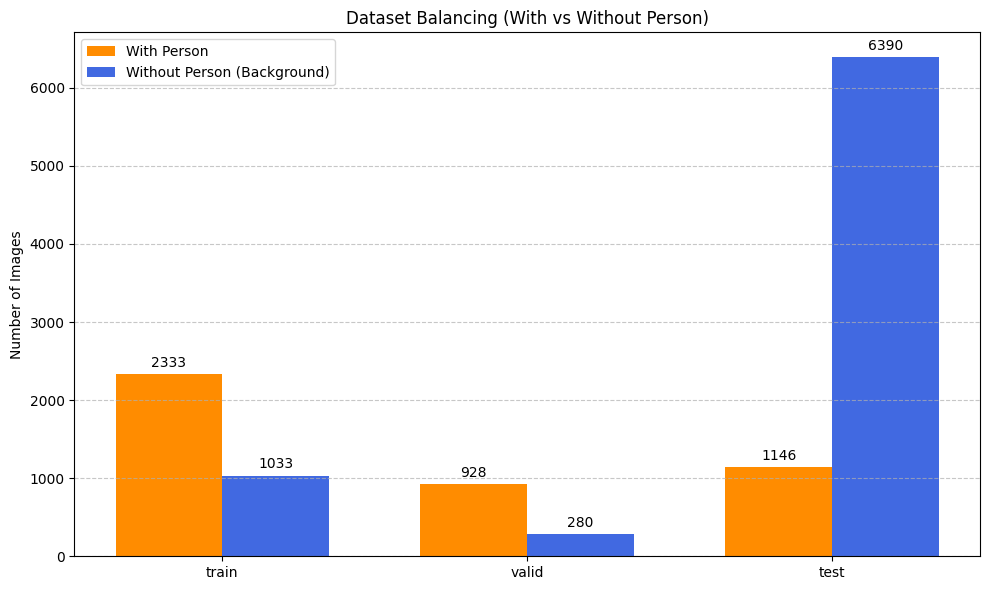

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

#CONFIGURATION

#Make sure this matches your OUTPUT_BASE_DIR
DATASET_DIR = "/kaggle/working/dataset_tiled" 
SUBSETS = ['train', 'valid', 'test']

def analyze_dataset_balance(base_dir, subsets):
    stats = {
        'subset': [],
        'with_person': [],
        'empty': [],
        'total': []
    }

    print(f"{'SUBSET':<10} | {'TOTAL':<8} | {'PERSON':<8} | {'EMPTY':<8} | {'EMPTY %':<8}")
    print("-" * 60)

    for subset in subsets:
        img_dir = os.path.join(base_dir, subset, 'images')
        lbl_dir = os.path.join(base_dir, subset, 'labels')
        
        #Find all images
        images = glob.glob(f"{img_dir}/*.jpg") + glob.glob(f"{img_dir}/*.png")
        
        count_person = 0
        count_empty = 0
        
        for img_path in images:
            #Reconstruct label path
            filename = os.path.basename(img_path)
            label_name = os.path.splitext(filename)[0] + ".txt"
            label_path = os.path.join(lbl_dir, label_name)
            
            has_person = False
            #Check if label file exists and is not empty
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    #Read lines and check if there is at least one valid line
                    lines = [l.strip() for l in f.readlines() if l.strip()]
                    if len(lines) > 0:
                        has_person = True
            
            if has_person:
                count_person += 1
            else:
                count_empty += 1
        
        total = count_person + count_empty
        empty_ratio = (count_empty / total * 100) if total > 0 else 0
        
        #Save data for the plot
        stats['subset'].append(subset)
        stats['with_person'].append(count_person)
        stats['empty'].append(count_empty)
        stats['total'].append(total)
        
        print(f"{subset:<10} | {total:<8} | {count_person:<8} | {count_empty:<8} | {empty_ratio:.1f}%")

    return stats

def plot_histogram(stats):
    x = np.arange(len(stats['subset']))  #Label positions
    width = 0.35  #Bar width

    fig, ax = plt.subplots(figsize=(10, 6))
    
    #Create bars
    rects1 = ax.bar(x - width/2, stats['with_person'], width, label='With Person', color='darkorange')
    rects2 = ax.bar(x + width/2, stats['empty'], width, label='Without Person (Background)', color='royalblue')

    #Add text, title, and custom labels
    ax.set_ylabel('Number of Images')
    ax.set_title('Dataset Balancing (With vs Without Person)')
    ax.set_xticks(x)
    ax.set_xticklabels(stats['subset'])
    ax.legend()

    #Function to add labels on top of bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), 
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('dataset_balancing.png', dpi=300, bbox_inches='tight')
    #print("Saved: dataset_balancing.png")

    plt.show()

#EXECUTION
if os.path.exists(DATASET_DIR):
    data_stats = analyze_dataset_balance(DATASET_DIR, SUBSETS)
    plot_histogram(data_stats)
else:
    print(f"Error: The directory {DATASET_DIR} does not exist.")

In [ ]:
import os
import glob
import shutil
from tqdm.notebook import tqdm

#CONFIGURATION
#Folder where created the heridal tiles (destination)
DEST_BASE_DIR = "/kaggle/working/dataset_tiled"

#Root folder of the SARD dataset
SARD_ROOT_DIR = "/kaggle/input/sard-search-and-rescue/search-and-rescue" 

def merge_prestructured_sard():
    print("STARTING SARD DATASET MERGE (STRUCTURED)")
    
    mapping = {
        'train': 'train',
        'valid': 'valid',
        'test':  'train' 
    }
    
    total_copied = 0

    for sard_subset, dest_subset in mapping.items():
        
        src_img_dir = os.path.join(SARD_ROOT_DIR, sard_subset, "images")
        if not os.path.exists(src_img_dir):
             src_img_dir = os.path.join(SARD_ROOT_DIR, "images", sard_subset)
        
        src_lbl_dir = os.path.join(SARD_ROOT_DIR, sard_subset, "labels")
        if not os.path.exists(src_lbl_dir):
             src_lbl_dir = os.path.join(SARD_ROOT_DIR, "labels", sard_subset)

        if not os.path.exists(src_img_dir) or not os.path.exists(src_lbl_dir):
            print(f"WARNING: Cannot find folders for {sard_subset} in {SARD_ROOT_DIR}. Skipping.")
            continue

        final_img_dir = os.path.join(DEST_BASE_DIR, dest_subset, "images")
        final_lbl_dir = os.path.join(DEST_BASE_DIR, dest_subset, "labels")
        
        images = glob.glob(os.path.join(src_img_dir, "*.*")) # Grabs everything (jpg, png, jpeg)
        
        print(f"Transferring {sard_subset} ({len(images)} img) -> {dest_subset}...")
        
        for img_path in tqdm(images):
            filename = os.path.basename(img_path)
            name_no_ext = os.path.splitext(filename)[0]
            
            # Corresponding label path
            lbl_path = os.path.join(src_lbl_dir, name_no_ext + ".txt")
            
            if os.path.exists(lbl_path):
                # Rename to avoid overwriting
                new_img_name = f"sard_{sard_subset}_{filename}"
                new_lbl_name = f"sard_{sard_subset}_{name_no_ext}.txt"
                
                # Copy
                shutil.copy(img_path, os.path.join(final_img_dir, new_img_name))
                shutil.copy(lbl_path, os.path.join(final_lbl_dir, new_lbl_name))
                total_copied += 1
            else:
                # If label is missing in SARD, ignore the image (we don't want uncontrolled background)
                pass

    print(f"\n OPERATION COMPLETED. Total SARD images merged: {total_copied}")
    print(f"Note: SARD 'test' subset was merged into 'train' to boost training.")

# EXECUTE
if os.path.exists(DEST_BASE_DIR):
    merge_prestructured_sard()
else:
    print("ERROR: Run the HERIDAL Tiling script first!")

--- STARTING SARD DATASET MERGE (STRUCTURED) ---
Transferring train (4041 img) -> train...


  0%|          | 0/4041 [00:00<?, ?it/s]

Transferring valid (1144 img) -> valid...


  0%|          | 0/1144 [00:00<?, ?it/s]

Transferring test (570 img) -> train...


  0%|          | 0/570 [00:00<?, ?it/s]


 OPERATION COMPLETED. Total SARD images merged: 5755
Note: SARD 'test' subset was merged into 'train' to boost training.


SUBSET     | TOTAL    | PERSON   | EMPTY    | EMPTY % 
------------------------------------------------------------
train      | 7977     | 6289     | 1688     | 21.2%
valid      | 2352     | 1895     | 457      | 19.4%
test       | 7536     | 1146     | 6390     | 84.8%


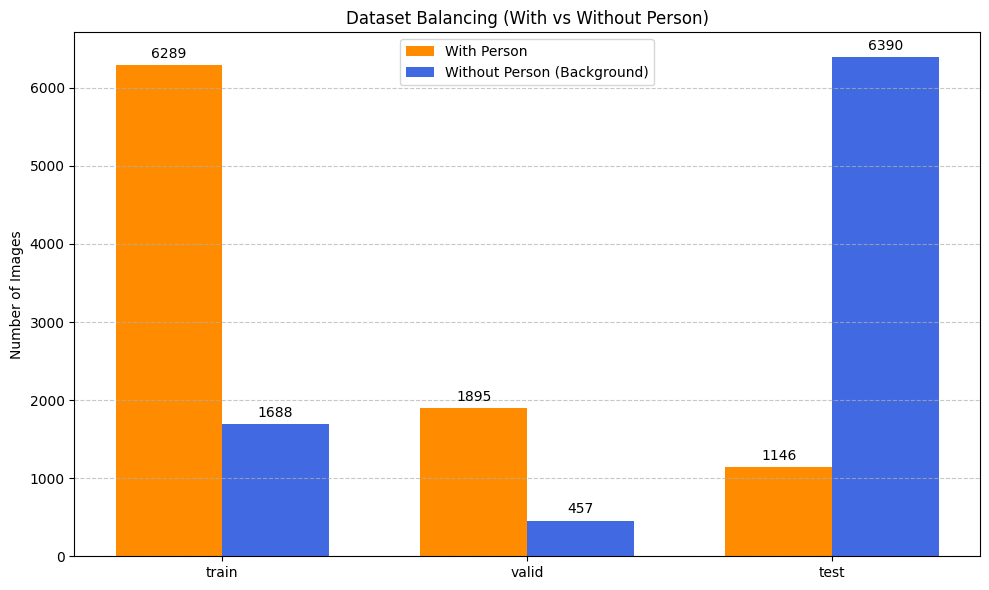

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

#CONFIGURATION
DATASET_DIR = "/kaggle/working/dataset_tiled" 
SUBSETS = ['train', 'valid', 'test']


#EXECUTION
if os.path.exists(DATASET_DIR):
    data_stats = analyze_dataset_balance(DATASET_DIR, SUBSETS)
    plot_histogram(data_stats)
else:
    print(f"Error: The directory {DATASET_DIR} does not exist.")

In [ ]:
import os
from ultralytics import YOLO

#CONFUGURATION
EPOCHS = 100
PROJECT_DIR = "/kaggle/working/runs"
RUN_NAME = "train_heridal_sard_yolo11n"

#Create logs folder if it doesn't exist
os.makedirs(PROJECT_DIR, exist_ok=True)

#YAML absolute paths for safety
yaml_content = f"""
path: {os.path.abspath('/kaggle/working/dataset_tiled')}
train: train/images
val: valid/images
test: test/images
names:
  0: person
"""

with open("heridal.yaml", "w") as f:
    f.write(yaml_content)

print(f"--- SETUP START ---")
"""
# Smart Resume Handling
last_ckpt = f"{PROJECT_DIR}/{RUN_NAME}/weights/last.pt"
resume_training = False

if os.path.exists(last_ckpt):
    print(f"Found previous checkpoint: {last_ckpt}")
    print("Resuming training from where it left off...")
    model = YOLO(last_ckpt)
    resume_training = True
else:
    print(f"No checkpoint found. Starting new training from scratch.")

    model = YOLO('yolo11n.pt') 

# --- START TRAINING ---
try:
    model.train(
        data='heridal.yaml',
        epochs=EPOCHS,
        patience=15,       # Stop if no improvement for 15 epochs
        imgsz=640,
        batch=16,          # If GPU goes OOM (Out of Memory), lower to 8 or 4
        device=0,          # GPU
        project=PROJECT_DIR,
        name=RUN_NAME,
        save_period=10,    # Save weights every 10 epochs
        save=True,
        resume=resume_training,
        
        # Augmentation (Optimized for SAR)
        degrees=15.0,      # Slight rotation
        fliplr=0.5,        # Horizontal flip
        flipud=0.5,        # Vertical flip (useful for drones)
        mosaic=1.0,        # Crucial for small objects
        mixup=0.1,         # Helps a bit with background
        scale=0.5,         # Scale variation (important for mixing SARD/HERIDAL)
        
        workers=2,         # 0 is slow, try 2 or 4 on Kaggle
        verbose=True
    )

except Exception as e:
    print(f"CRITICAL ERROR DURING TRAINING: {e}")

print("Training Completed or Interrupted.")"""

--- SETUP START ---


'\n# Smart Resume Handling\nlast_ckpt = f"{PROJECT_DIR}/{RUN_NAME}/weights/last.pt"\nresume_training = False\n\nif os.path.exists(last_ckpt):\n    print(f"Found previous checkpoint: {last_ckpt}")\n    print("Resuming training from where it left off...")\n    model = YOLO(last_ckpt)\n    resume_training = True\nelse:\n    print(f"No checkpoint found. Starting new training from scratch.")\n\n    model = YOLO(\'yolov8n.pt\') \n\n# --- START TRAINING ---\ntry:\n    model.train(\n        data=\'heridal.yaml\',\n        epochs=EPOCHS,\n        patience=15,       # Stop if no improvement for 15 epochs\n        imgsz=640,\n        batch=16,          # If GPU goes OOM (Out of Memory), lower to 8 or 4\n        device=0,          # GPU\n        project=PROJECT_DIR,\n        name=RUN_NAME,\n        save_period=10,    # Save weights every 10 epochs\n        save=True,\n        resume=resume_training,\n        \n        # Augmentation (Optimized for SAR)\n        degrees=15.0,      # Slight rotation

In [ ]:
"""import shutil
import os
from IPython.display import FileLink

#Set the exact path provided by YOLO
output_folder = "/kaggle/working/runs/train_heridal_sard"
zip_name = "FINAL_RESULTS_SARD_11n"

#Check and Zip Creation
if os.path.exists(output_folder):
    print(f"Folder found: {output_folder}")
    print("Creating zip file (this will take a few seconds)...")

    #Create the zip
    shutil.make_archive(zip_name, 'zip', output_folder)

    print("DONE! Click the link below to download:")
    #Generate Blue Link
    display(FileLink(f'{zip_name}.zip'))
else:
    print(f"Error: Cannot find folder '{output_folder}'. Check the right sidebar to see if the name is different.")"""

In [ ]:
#TEST VALIDATION SET

import os
from ultralytics import YOLO

#CONFIGURATION
DATASET_DIR = "/kaggle/working/dataset_tiled"
YAML_FILENAME = "heridal_full_valid.yaml"

#CREATE YAML
yaml_content = f"""
path: {DATASET_DIR}
train: valid/images
val: valid/images
test: test/images

names:
  0: person
"""

with open(YAML_FILENAME, "w") as f:
    f.write(yaml_content)

print(f"YAML File created: {YAML_FILENAME}")

#LOAD MODEL
#Use the path to best.pt
model_path = "/kaggle/input/sard-yolo11m/best (4).pt"

if not os.path.exists(model_path):
    if os.path.exists("best.pt"):
        model_path = "best.pt"
    elif os.path.exists("/kaggle/input/sard-yolo11m/best (4).pt"):
        model_path = "/kaggle/input/sard-yolo11m/best (4).pt"
    else:
        print("WARNING: Cannot find best.pt, check your paths.")

print(f"Loading model from: {model_path}")

try:
    model = YOLO(model_path)

    #START VALIDATION
    print(f"\nStarting validation on {DATASET_DIR} (Split: TEST)...")
    print("This might take a few minutes as the dataset is complete...")
    
    metrics = model.val(
        data=YAML_FILENAME,
        split='val',        
        imgsz=640,
        batch=16,
        conf=0.001,          
        iou=0.6,
        device=0             
    )

    #RESULTS
    print("\n" + "="*40)
    print(f"OFFICIAL RESULTS ON COMPLETE DATASET YOLO11m")
    print("="*40)
    print(f"Precision:    {metrics.box.mp:.3f}")
    print(f"Recall:       {metrics.box.mr:.3f}")
    print(f"mAP@50:       {metrics.box.map50:.3f}")
    print(f"mAP@50-95:    {metrics.box.map:.3f}")
    print("="*40)

except Exception as e:
    print(f"\nERROR: {e}")

YAML File created: heridal_full_valid.yaml
Loading model from: /kaggle/input/sard-yolo11m/best (4).pt

Starting validation on /kaggle/working/dataset_tiled (Split: TEST)...
This might take a few minutes as the dataset is complete...
Ultralytics 8.3.241 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2445.9±337.2 MB/s, size: 133.2 KB)
val: Scanning /kaggle/working/dataset_tiled/valid/labels.cache... 2072 images, 457 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2352/2352 4.5Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 147/147 2.0it/s 1:130.5sss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2352       2627      0.915      0.815      0.884      0.555
Speed: 0.9ms preprocess, 27.5ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /kaggle/working/runs/detect/val8

OFFICIAL RESULTS ON COMPLETE DATASET YOLO11m
Precision:    0.915
Recall:       0.815
mAP@50:       0.884
mAP@50-95:    0.555


In [ ]:
with open("heridal_tuning.yaml", "w") as f:
    f.write(yaml_content)

'''
#EXPERIMENT A: Baseline (Raw)
print("Running: BASELINE (Conf 0.25, No TTA)...")
res_base = model.val(data='heridal.yaml', split='val', imgsz=640, conf=0.25, augment=False)
print(f" -> mAP@50: {res_base.box.map50:.4f}")

#EXPERIMENT B: With TTA
print("--- STUDY 1: IMPACT OF TTA (Test Time Augmentation) ---")
'''

#With TTA
print("\n2. Running WITH TTA (Augment=True)...")
metrics_tta = model.val(data='heridal_tuning.yaml', split='val', imgsz=640, conf=0.001, augment=True)

#Comparison
delta = metrics_tta.box.mr - metrics.box.mr 

print(f"\nRESULT:")
print(f"Recall No-TTA: {metrics.box.mr:.4f}")
print(f"Recall TTA:    {metrics_tta.box.mr:.4f}")
print(f"Difference:    {delta:+.4f}")

if delta > 0: 
    print("CONCLUSION: TTA improves performance.")
else: 
    print("CONCLUSION: TTA does not help (or barely affects it).")


2. Running WITH TTA (Augment=True)...
Ultralytics 8.3.241 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2771.0±614.7 MB/s, size: 150.5 KB)
val: Scanning /kaggle/working/dataset_tiled/valid/labels.cache... 2072 images, 457 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2352/2352 4.6Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 147/147 1.1s/it 2:341.0ss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2352       2627      0.907      0.795      0.872      0.552
Speed: 0.9ms preprocess, 62.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /kaggle/working/runs/detect/val9

RESULT:
Recall No-TTA: 0.8146
Recall TTA:    0.7952
Difference:    -0.0194
CONCLUSION: TTA does not help (or barely affects it).


In [ ]:
#TEST SET

import os
from ultralytics import YOLO

#CONFIGURATION
DATASET_DIR = "/kaggle/working/dataset_tiled"
YAML_FILENAME = "heridal_full_valid.yaml"

#CREATE YAML
yaml_content = f"""
path: {DATASET_DIR}
train: valid/images
val: valid/images
test: test/images

names:
  0: person
"""

with open(YAML_FILENAME, "w") as f:
    f.write(yaml_content)

print(f"YAML File created: {YAML_FILENAME}")

#LOAD MODEL
model_path = "/kaggle/input/sard-yolo11m/best (4).pt"

if not os.path.exists(model_path):
    if os.path.exists("best.pt"):
        model_path = "best.pt"
    elif os.path.exists("/kaggle/input/sard-yolo11m/best (4).pt"):
        model_path = "/kaggle/input/sard-yolo11m/best (4).pt"
    else:
        print("WARNING: Cannot find best.pt! Check your paths.")

print(f"Loading model from: {model_path}")

try:
    model = YOLO(model_path)

    #START TEST
    print(f"\nStarting validation on {DATASET_DIR} (Split: TEST)...")
    print("This might take a few minutes as the dataset is complete...")
    
    metrics = model.val(
        data=YAML_FILENAME,
        split='test',        
        imgsz=640,
        batch=16,
        conf=0.001,          
        iou=0.6,
        device=0             
    )

    #RESULTS
    print("\n" + "="*40)
    print(f"OFFICIAL RESULTS ON COMPLETE DATASET YOLO11m")
    print("="*40)
    print(f"Precision:    {metrics.box.mp:.3f}")
    print(f"Recall:       {metrics.box.mr:.3f}")
    print(f"mAP@50:       {metrics.box.map50:.3f}")
    print(f"mAP@50-95:    {metrics.box.map:.3f}")
    print("="*40)

except Exception as e:
    print(f"\nERROR: {e}")

YAML File created: heridal_full_valid.yaml
Loading model from: /kaggle/input/sard-yolo11m/best (4).pt

Starting validation on /kaggle/working/dataset_tiled (Split: TEST)...
This might take a few minutes as the dataset is complete...
Ultralytics 8.3.241 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2757.9±623.9 MB/s, size: 174.5 KB)
val: Scanning /kaggle/working/dataset_tiled/test/labels.cache... 1146 images, 6390 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 7536/7536 9.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 471/471 2.1it/s 3:41<0.5s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       7536       1941      0.635      0.646      0.659      0.363
Speed: 0.8ms preprocess, 27.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /kaggle/working/runs/detect/val10

OFFICIAL RESULTS ON COMPLETE DATASET YOLO11m
Precision:    0.635
Recall:       0.646
mAP@50:       0.659
mAP@50-95:    0.363
